In [ ]:
# -*- coding: utf-8 -*-

"""

@ author: Taehyeong Kim

"""

import numpy as np
from scipy.stats import uniform
import pandas as pd
from pandas.plotting import autocorrelation_plot

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from fbprophet import Prophet

## Data Preprocessing

In [ ]:
train = pd.read_csv("data/train_3000seq.csv")
test = pd.read_csv("data/test_600seq.csv")
train.columns

Index(['time', 'P1_B2016', 'P1_B4022', 'P1_FCV02Z', 'P1_FCV03D', 'P1_FCV03Z',
       'P1_FT01', 'P1_FT01Z', 'P1_FT02', 'P1_LCV01D', 'P1_LCV01Z', 'P1_PCV02Z',
       'P1_PIT01', 'P1_PIT02', 'P1_TIT01', 'P1_TIT02', 'P2_24Vdc', 'P2_SIT01',
       'P2_VT01e', 'P2_VXT02', 'P2_VXT03', 'P2_VYT02', 'P2_VYT03', 'P3_LCP01D',
       'P3_LT01', 'P4_HT_FD', 'P4_HT_LD', 'P4_LD', 'P4_ST_FD', 'P4_ST_LD',
       'P4_ST_PO', 'P4_ST_PT01', 'P4_ST_TT01', 'attack', 'P1_B3004+P1_LIT01',
       'P1_B3005+P1_FT03+P1_FT03Z', 'P1_B400B+P1_FT02Z', 'P1_FCV01D+P1_FCV01Z',
       'P1_PCV01D+P1_PCV01Z', 'P3_LCV01D+P4_HT_PO'],
      dtype='object')

In [ ]:
train["time"]=pd.to_datetime(train["time"])
test["time"]=pd.to_datetime(test["time"])

test.index=test.index+len(train)
print(test.index)

dt_index = pd.date_range(start='17000101', end='20201207')
train["ds"]=dt_index[-(len(train)+len(test)):-len(test)]
test["ds"]=dt_index[-len(test):]
test.tail()

RangeIndex(start=3000, stop=3600, step=1)


,time,P1_B2016,P1_B4022,P1_FCV02Z,P1_FCV03D,P1_FCV03Z,P1_FT01,P1_FT01Z,P1_FT02,P1_LCV01D,...,P4_ST_PT01,P4_ST_TT01,attack,P1_B3004+P1_LIT01,P1_B3005+P1_FT03+P1_FT03Z,P1_B400B+P1_FT02Z,P1_FCV01D+P1_FCV01Z,P1_PCV01D+P1_PCV01Z,P3_LCV01D+P4_HT_PO,ds
3595,2019-11-04 15:39:29,1.5253,33.4769,96.4752,80.8528,82.3532,210.2280,873.9625,6.5231,19.2437,...,10026.0,27478.0,0,372.78160,864.023867,33.96365,0.12665,79.08945,7804.51255,2020-12-03
3596,2019-11-04 15:39:30,1.5214,33.4669,96.4752,80.7688,82.3456,210.0372,918.3198,7.2860,19.4093,...,10003.0,27482.0,0,372.90940,864.087467,32.47405,0.12665,79.19845,7780.39505,2020-12-04
3597,2019-11-04 15:39:31,1.5180,33.4586,96.4828,80.6713,82.2922,205.6503,917.8848,6.3324,19.5200,...,10000.0,27479.0,0,373.01160,864.702433,35.94985,0.12665,79.30900,7748.27750,2020-12-05
3598,2019-11-04 15:39:32,1.5112,33.4414,96.4828,80.4789,82.3532,212.1353,907.8827,7.0953,19.5454,...,9999.0,27475.0,0,373.13940,865.234933,35.45320,0.12665,79.37405,7724.12380,2020-12-06
3599,2019-11-04 15:39:33,1.5044,33.4246,96.4676,80.4504,82.2845,204.6967,922.6685,5.9509,19.7204,...,10000.0,27480.0,0,373.11385,865.212067,34.95675,0.12665,79.43855,7692.03335,2020-12-07


In [ ]:
train_X=train.drop("attack", axis=1)
test_X=test.drop("attack", axis=1)
test_y=test["attack"]
test_y.value_counts()

1    386
0    214
Name: attack, dtype: int64

In [ ]:
scaler = MinMaxScaler().fit(train_X.iloc[:,1:-1])
X_train=scaler.transform(train_X.iloc[:,1:-1])
X_test=scaler.transform(test_X.iloc[:,1:-1])
train_X.iloc[:,1:-1]=X_train
test_X.iloc[:,1:-1]=X_test
train_X.head()

,time,P1_B2016,P1_B4022,P1_FCV02Z,P1_FCV03D,P1_FCV03Z,P1_FT01,P1_FT01Z,P1_FT02,P1_LCV01D,...,P4_ST_PO,P4_ST_PT01,P4_ST_TT01,P1_B3004+P1_LIT01,P1_B3005+P1_FT03+P1_FT03Z,P1_B400B+P1_FT02Z,P1_FCV01D+P1_FCV01Z,P1_PCV01D+P1_PCV01Z,P3_LCV01D+P4_HT_PO,ds
0,2019-11-04 14:39:35,0.742097,0.742205,0.42098,0.732727,0.479741,0.416666,0.280302,0.499967,0.232574,...,0.742697,0.035714,0.979798,0.959014,0.463091,0.208345,0.75082,0.999234,0.900229,2011-01-30
1,2019-11-04 14:39:36,0.741428,0.741469,0.73706,0.724084,0.479741,0.575756,0.416666,0.437480,0.208978,...,0.744605,0.035714,0.969697,0.967208,0.486689,0.333340,0.75082,0.999234,0.901144,2011-01-31
2,2019-11-04 14:39:37,0.748620,0.748628,0.63147,0.707967,0.479741,0.439393,0.575758,0.437480,0.191813,...,0.751401,0.035714,1.000000,0.942610,0.519112,0.416673,0.75082,0.999234,0.902055,2011-02-01
3,2019-11-04 14:39:38,0.741930,0.742005,0.63147,0.717779,0.479741,0.378786,0.439391,0.312504,0.182905,...,0.749493,0.035714,0.969697,0.950820,0.530983,0.375011,0.75082,0.999234,0.902969,2011-02-02
4,2019-11-04 14:39:39,0.746780,0.746822,0.26294,0.694850,0.479741,0.257576,0.378789,0.624975,0.181297,...,0.751401,0.035714,0.888889,0.942610,0.527946,0.291678,0.75082,0.999234,0.902974,2011-02-03


## Prophet

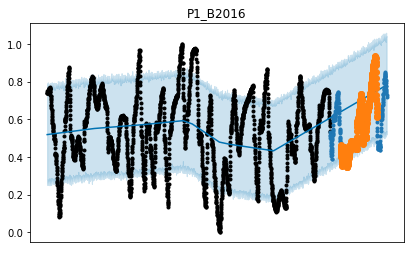

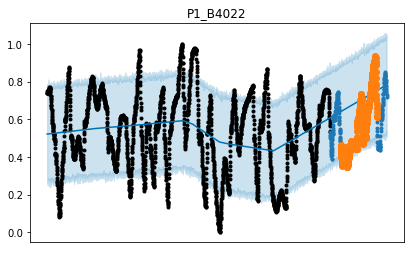

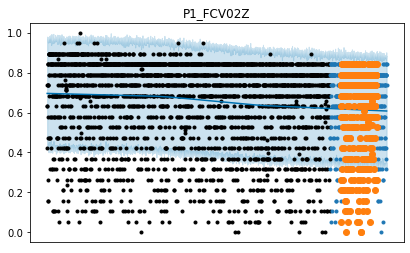

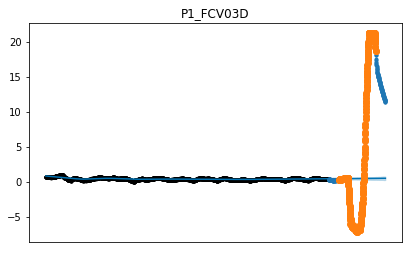

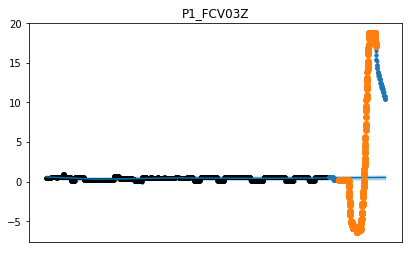

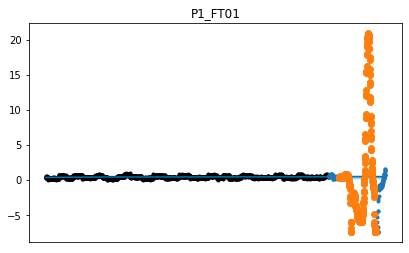

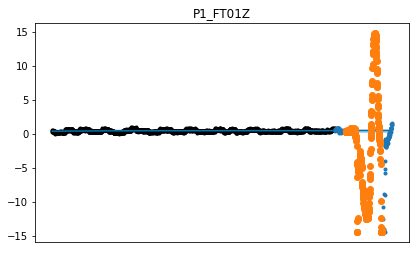

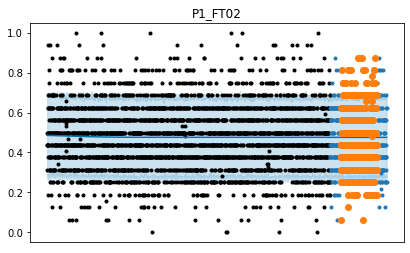

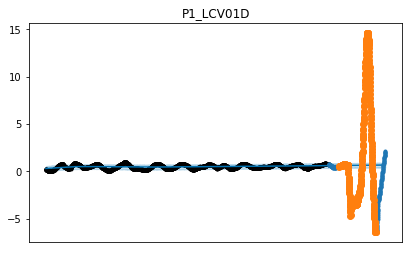

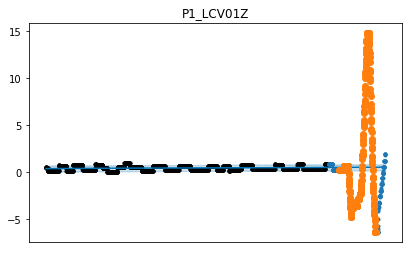

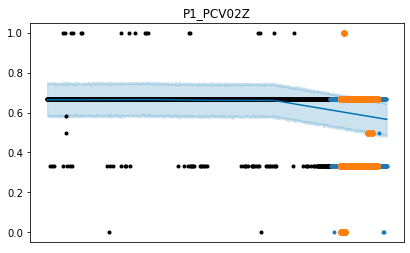

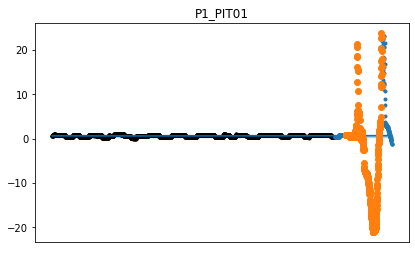

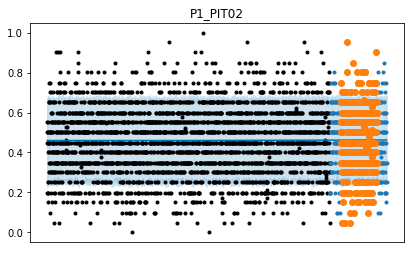

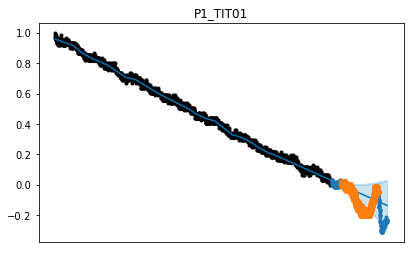

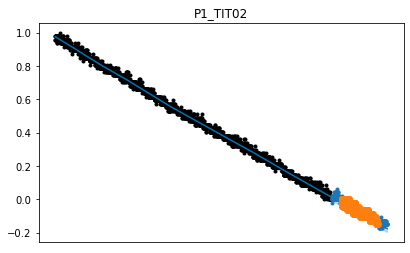

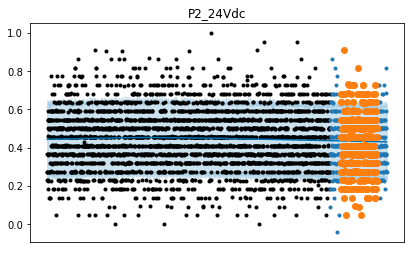

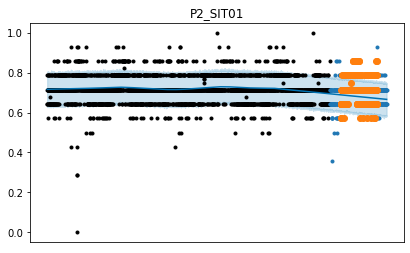

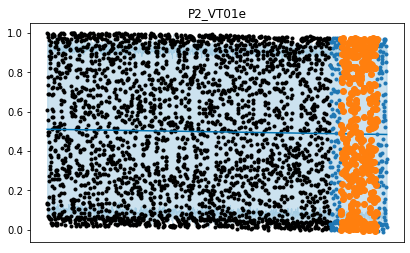

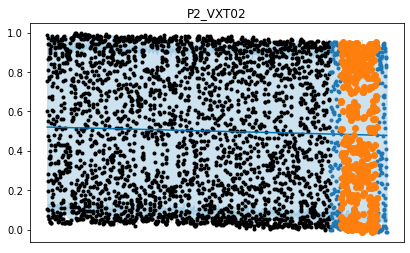

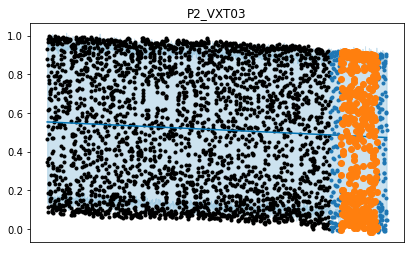

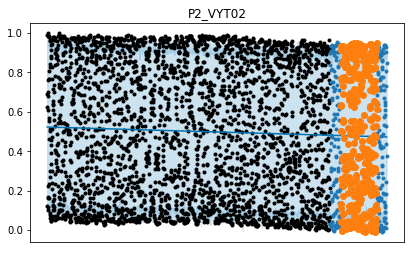

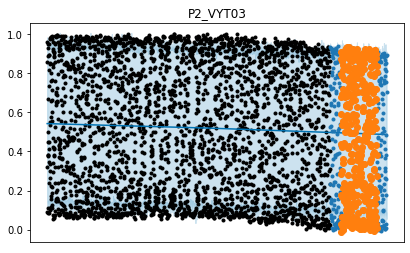

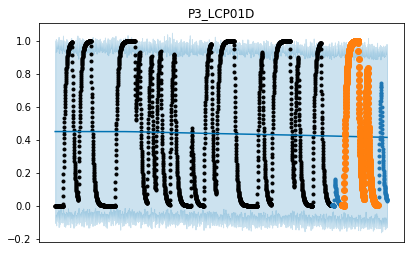

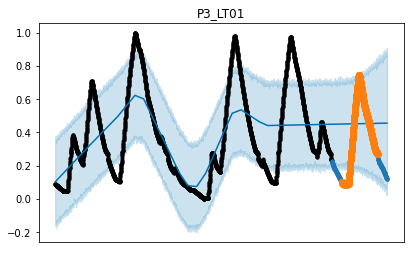

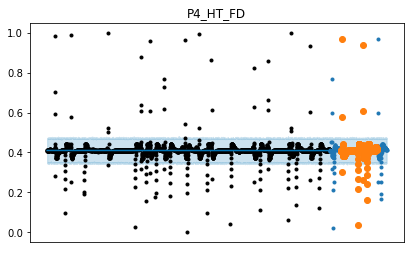

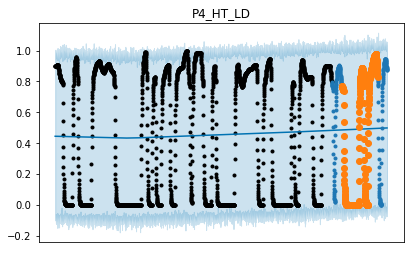

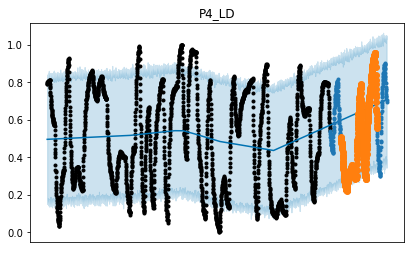

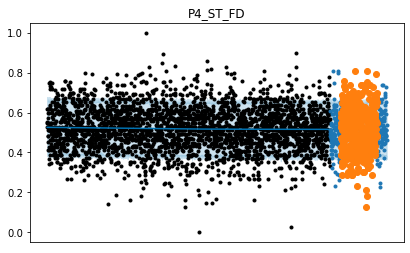

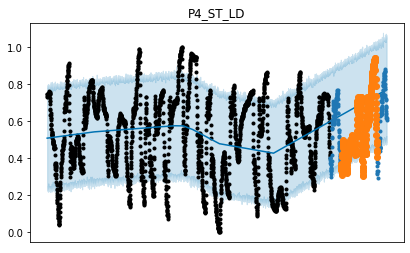

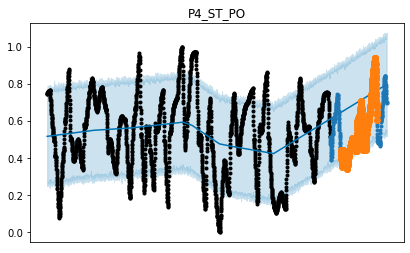

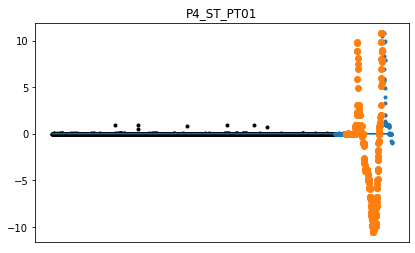

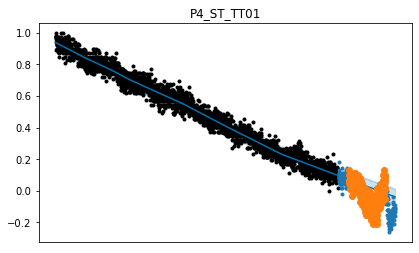

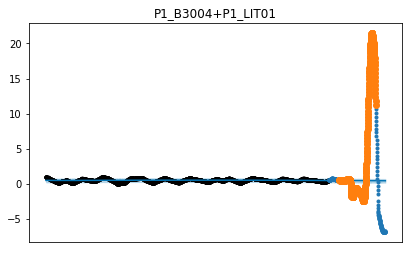

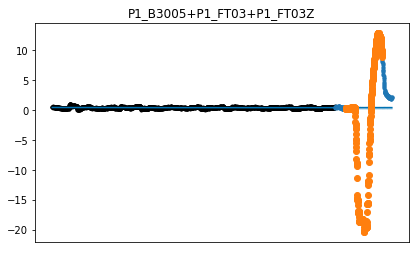

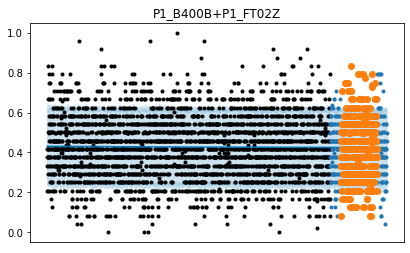

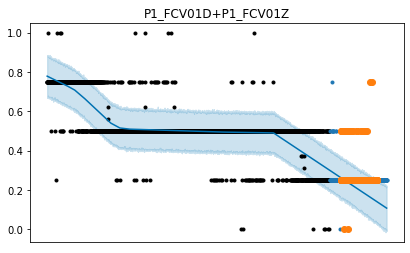

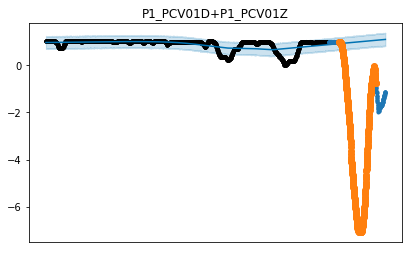

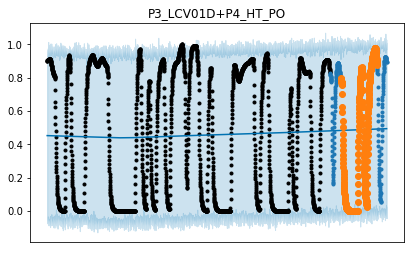

In [ ]:
feature_bag={}
for col in train_X.columns.drop(["time", "ds"]):
    
    df=train_X[["ds", col]]
    df.columns=["ds", "y"]
    
#     autocorr=df.set_index("ds").iloc[:60]
#     autocorrelation_plot(autocorr)
#     plt.title(str(col))
#     plt.show()
    
    m = Prophet(yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=True)
    m.fit(df)
    future = m.make_future_dataframe(periods=len(test))
    forecast = m.predict(future)
    fig1 = m.plot(forecast, figsize=(6, 4))
    
    y_true=test_X.set_index("ds")[col]
    y_true.iloc[test[test["attack"]==0].index-len(train)].plot(linestyle='None', marker=".")
    y_true.iloc[test[test["attack"]==1].index-len(train)].plot(linestyle='None', marker='o')
    
    plt.title(str(col))
    plt.xticks([])
    plt.xlabel(None)
    plt.ylabel(None)
#     plt.savefig(f'figure/{col}.png', bbox_inches='tight')
    plt.show()
    
    feature_bag[col]=forecast#[['yhat', 'yhat_lower', 'yhat_upper']]

In [ ]:
# for _ in train_X.columns.drop(["time", "ds"]):
#     feature_bag[_][['yhat', 'yhat_lower', 'yhat_upper']].to_csv("results/"+str(_)+".csv", index=None)
# print("--end--")